Exercise 10: Phase transitions in the Ising Model
=================================================
<img src="ising.png" style="max-width:30%; float:right; padding-left:30pt">

The [Ising model] is perhaps the most important model in all of solid state physics, certainly
one of the most significant from a historical perspective.  This is because it is a simple
microscopic, atomistic model from which a (macroscopic) magnetic phase transition can be shown to *[emerge]*.
Its introduction finally to rest a [debate] over whether statistical mechanics works and even whether atoms are real that continued well into the twentieth century.

The idea is the following: consider a $N\times N$ square grid of atoms (we will take $N = 40$).  The atom at each position $(i,j)$ is fixed in place, but is endowed with a **spin** $\sigma_{i,j}$ which can either be $+1$ or $-1$ (pointing up or down) at any given moment.  One such configuration can be seen on the right: the top-left spin $\sigma_{1,1}=1$, the one two columns to the right $\sigma_{1,3}= -1$, and so forth.  The potential energy $U$ encoded in each configuration is given by:

$$
   U = -\sum_{i,j} \big[ \sigma_{i,j} \sigma_{i,j+1} + \sigma_{i,j} \sigma_{i+1,j} \big],
$$

in other words, we have a positive contribution to the potential energy $\Delta U = 1$ whenever two neighbouring  spins are opposite to each other and a negative energy contribution $\Delta U = -1$ whenever two neighbouring spins are aligned.  Competing with the systems desire to lower its potential energy is temperature $T$, which introduces kinetic energy by randomly flipping spins.

We want to explore this competiton between kinetic and potential energy.  For this, I  have prepared a set of $N$ snapshots of the spins $\sigma^{(n)}_{i,j}$ taken at different times, stored in the $N\times L \times L$ tensor `spins`, together with their respective temperatures $T_n$, stored in a vector `temp`.

Each of these observations may belong to a "phase" $y_n$ of the material, which is unknown to us.  However, we suspect that similar phases have similar properties.  The idea is find different these without any knowledge of the phases themselves by using k-means clustering.

[Ising model]: https://en.wikipedia.org/wiki/Ising_model
[emerge]: https://en.wikipedia.org/wiki/Emergence
[debate]: https://www.worldcat.org/title/ludwig-boltzmann-the-man-who-trusted-atoms/oclc/874232031

In [2]:
import os
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.colors as mcol
from random import choice

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vcwczqlb because the default path (/home/e00473828/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Load the dataset from a binary file
with np.load(os.path.expanduser("~/shared/ising.npz")) as _datafile:
    spins = _datafile["spins"]
    temp = _datafile["temp"]

Let us first make a warm-up plot: make a false-color plot of the $n=140,000$'th spin configuration
similar to the figure above, where you use one color to denote spin-down ($\sigma_{ij}=-1$)
and another color to denote spin-up ($\sigma_{ij}=1$).

Text(0.5, 1.0, 'Visualisation of spins at n = 140 000')

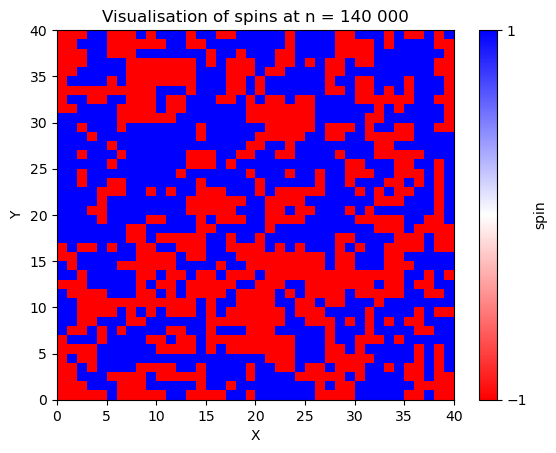

In [15]:
pl.pcolormesh(spins[140000], vmin=-1, vmax=1, cmap="bwr_r")
pl.colorbar(ticks=(-1, 1), label="spin")
pl.xlabel('X')
pl.ylabel('Y')
pl.title('Visualisation of spins at n = 140 000')

Step 1: Compute observables
---------------------------
Clustering in high dimensions (which is what we would do if we work with the spin array directly) is
difficult to perform and also visualize.  Therefore we are going to reduce each configuration ($s^{(n)}_{i,j}$
for a fixed $n$) to just two observables: the **magnetization** $m$, which we will store in `magn`, and the
**staggered magnetization** $m'$, which we will store in `smagn`.

The definitions are:
$$
    m_n = \frac 1{L^2} \sum_{i,j} \sigma^{(n)}_{i,j}
$$
$$
    m'_n = \frac 1{L^2} \sum_{i,j} (-1)^{i+j} \sigma^{(n)}_{i,j}
$$

Compute the two numpy vectors `magn` and `smagn` according to above formula

In [16]:
L2 = spins.shape[1] * spins.shape[2]

magn = np.sum(spins, axis=(1,2)) / L2
smagn = np.sum(spins * -(2*(np.indices((spins.shape[1],spins.shape[2])).sum(axis=0) % 2) - 1), axis=(1, 2)) / L2

# Note:
# np.indices((spins.shape[1],spins.shape[2])).sum(axis=0) % 2
# creates a checkerboard pattern of 0 and 1 which I map to -1, 1 and the multiply onto spins

In [17]:
assert (magn, smagn) is not None
assert magn.shape == smagn.shape == (160_000,)
assert np.all(np.abs(magn) <= 1)
assert np.all(np.abs(smagn) <= 1)

np.testing.assert_allclose(magn.sum(), 191.63875, rtol=1e-4)
np.testing.assert_allclose(smagn.sum(), 5.68875, rtol=1e-4)

Now, perform a scatter plot, where each point is one observation, the $x$-axis corresponds to the magnetization of that observation, the $y$ axis corresponds to the staggered magnetization of the observation and the color corresponds to the temperature.  Also add a colorbar

Choose a small marker size (`s` argument), otherwise you not see much in the plot

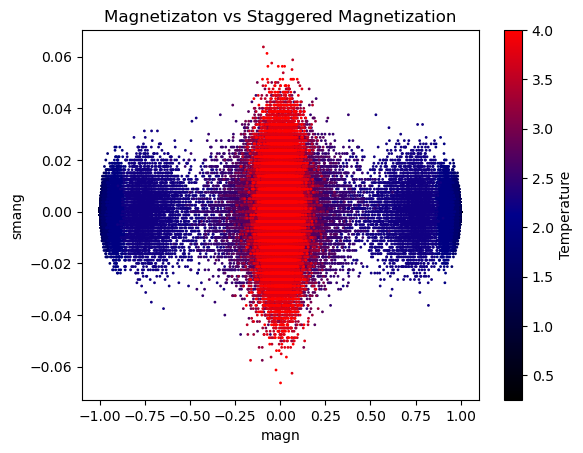

In [18]:
cm = mcol.LinearSegmentedColormap.from_list("CustomCmap",["black", "darkblue", "red"])
pl.scatter(magn, smagn, s=1, c=temp, cmap=cm)
pl.colorbar(label='Temperature');

pl.xlabel('magn')
pl.ylabel('smang')
pl.title('Magnetizaton vs Staggered Magnetization');

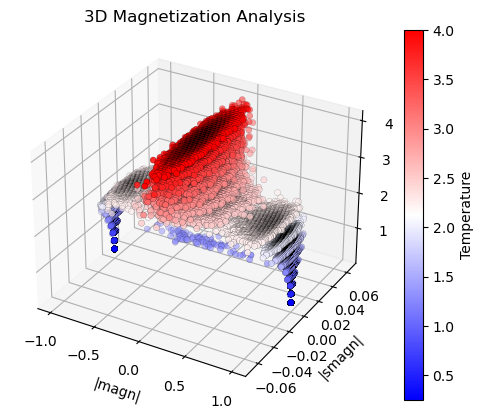

In [19]:
# Create a figure and a 3D axis
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot
scatter = ax.scatter(magn, smagn, temp, c=temp, cmap="bwr", edgecolors="black", linewidth=0.15)
cbar = pl.colorbar(scatter)
cbar.set_label('Temperature')

# Set labels and title
ax.set_xlabel('|magn|')
ax.set_ylabel('|smagn|')
ax.set_zlabel('Temperature')
ax.set_title('3D Magnetization Analysis');
pl.show()

Step 2:  Clustering, first round
--------------------------------
Your plot above should suggest to use three clusters.

Perform a cluster analysis using the `sklearn.cluster.KMeans` clustering
algorithm.  For this, first collect `magn` and `smagn` as columns of a `N x 2` design matrix
`X` and then run the fitting.

In [21]:
import sklearn.cluster

In [22]:
X = np.vstack((magn, smagn)).T
kmeans = sklearn.cluster.KMeans(n_clusters=3, n_init='auto').fit(X)

Now, repeat the scatter plot from above, but instead of temperature, plot each point together in
different colors depending on their cluster label.

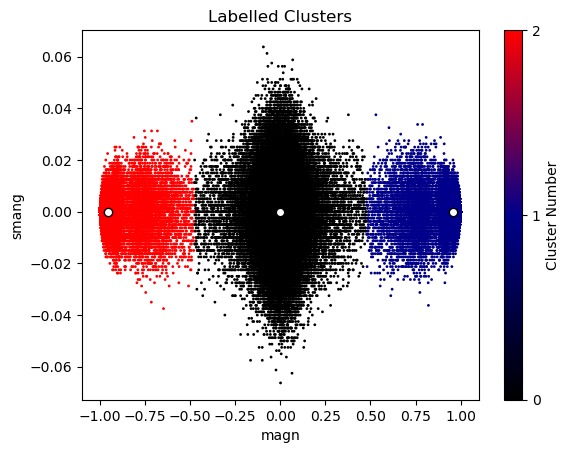

In [24]:
pl.scatter(magn, smagn, s=1, c=kmeans.labels_, cmap=cm)
pl.colorbar(ticks=(0, 1, 2), label="Cluster Number")
pl.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c="white", marker="o", edgecolor='k', label="Cluster Centers")

pl.xlabel('magn')
pl.ylabel('smagn')
pl.title('Labelled Clusters');

Let us get a feeling for the kind of configurations in each of the clusters:
for each cluster, pick two configurations at random and make a false color
plot for them.  You should therefore end up with a 2 x 3 matrix of plots,
where the columns correspond to the different clusters and rows are the
different configurations

**Note**: if all the spins are +1 or -1, then the colorbar gets confused,
since there is only one value.  You can pass  `(..., vmin=-1, vmax=1)` arguments
to false color plots to combat this.

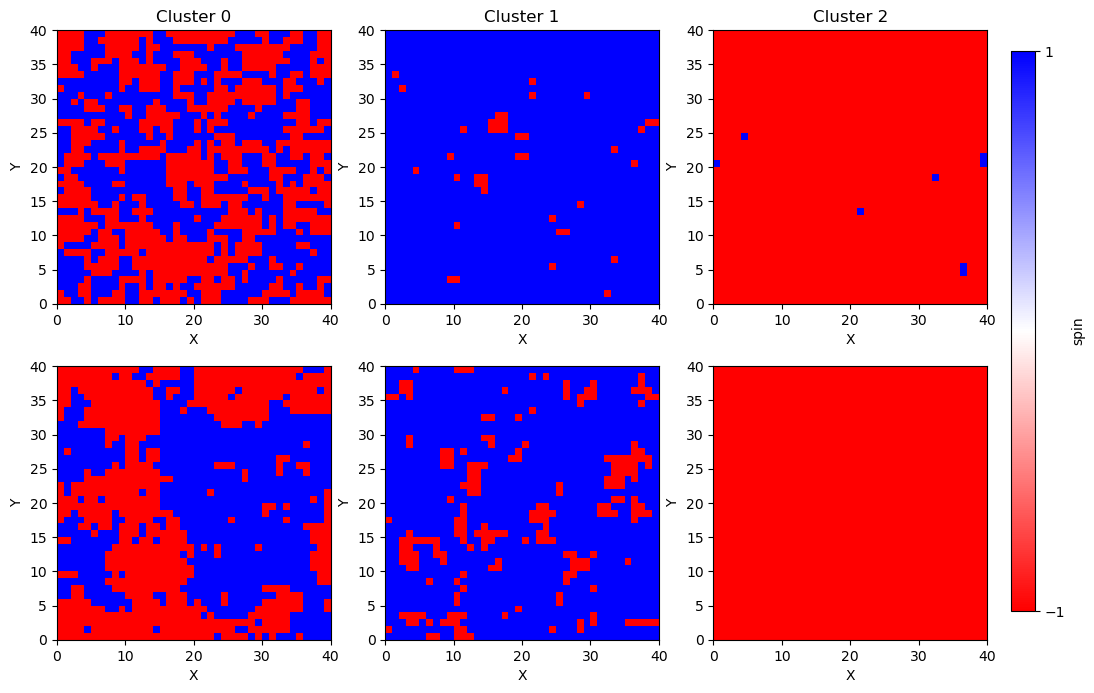

In [30]:
def get_random_from_cluster(labels, target_label):
    indices = [index for index, label in enumerate(labels) if label == target_label]
    if indices:
        return choice(indices)
    else:
        return None

def gridplot(kmeans, samples=2):  
    # Create sample data
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)

    # Create the figure and axes
    fig, axes = pl.subplots(samples, 3, figsize=(12, 4 * samples))

    # Plot the pcolormesh in each subplot
    for i in range(3):
        for j in range(samples):
            ax = axes[j, i]
            im = ax.pcolormesh(spins[get_random_from_cluster(kmeans.labels_, i)], vmin=-1, vmax=1, cmap="bwr_r")
            ax.set_aspect('equal')  # Set aspect ratio to make the plot square
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
            if j == 0:
                ax.set_title(f'Cluster {i}')

    # Add a colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, ticks=(-1, 1), label="spin")

    # Show the figure
    pl.show()

gridplot(kmeans)

Interpret your results:

 1. What do the three clusters correspond to in the model?
 
 2. Compare the scatter plots for temperature and for cluster labels?
    What can you conclude about the behaviour of the system at different
    temperatures?
    
 3. Think about the competing energies in the system.  How does this
    explain what you find?
    
 4. Note that our system has a **symmetry**: if we flip all spins in a given 
    configuration, the energy stays the same.  How does this enter our
    analysis?

### 1)
**Cluster 0** contains configurations where the magnetization is close to 0, and thus this means that most particles have a random spin overall there are a similar amount of up and down spins

**Cluster 1 and 2** correspond to configurations where either the up or the down spin respectively dominate, and almost the entire sample has the same spin.

### 2)
The plot showing cluster labels and the plot showing the temperatures are quite similar. The region with high temperature corresponds to the cluster 0 label. This makes sense because at high temperature the kinetic energy dominates and causes spins to flip randomly with little regard for their neighbours. Thus we get a mostly random arrangement of spins with neither spin dominating.

For low temperatures the incresed potential energy of having two opposing spins next to each other dominates over the kinetic energy and thus we see the formation of a global structure which causes most of the spins to align in either the up or down directions.

### 3)
At higher temperatures the thermal fluctuations win out over the potential energy from local ordering of spins, thus we see a mainly random arrangement with no global stucture and hence very little magnitisation.

If temperature is low then the thermal fluctuations aren't strong enough to cause spins to flip and the entire system will have large areas where all spins are aligned.

### 4)
Because the energy does not change when all the spins flip, this means that we have a degenerate ground state, and would actually like to have both these cases grouped into one cluster. But since we performed the clustering on the quatities of magnetisation and staggered magnetization, wich do not also share this symmetry, we get two seperate clusters. We can remedy this by using the absolute values of these quantities and redoing the analysis.

Step 3: Clustering, second round
--------------------------------
We would like to take the symmetry of our system into account.  Therefore,
instead of the (staggered) magnetization, we are using the **absolute**
values of each of these quantities.

Replace `magn` and `smagn` with a vector of their absolute values and
redo the scatter plot from above, where again color denotes temperature.

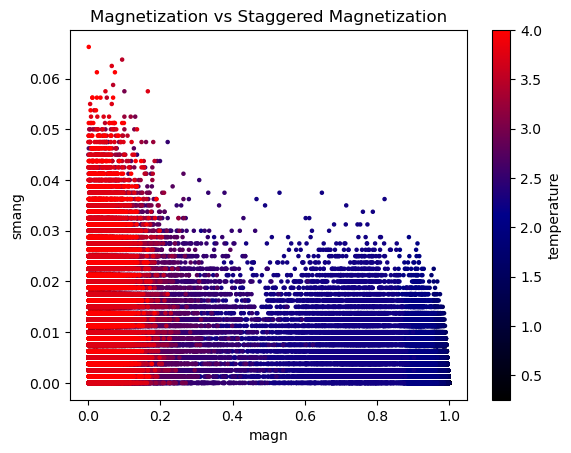

In [35]:
from copy import copy
magn_abs = np.abs(magn)
smagn_abs = np.abs(smagn)

pl.scatter(magn_abs, smagn_abs, s=5, c=temp, cmap=cm)
pl.colorbar(label="temperature");

pl.xlabel('magn')
pl.ylabel('smang')
pl.title('Magnetization vs Staggered Magnetization');

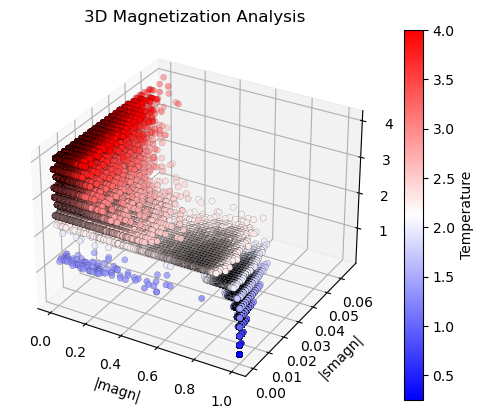

In [36]:
# Create a figure and a 3D axis
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot
scatter = ax.scatter(magn_abs, smagn_abs, temp, c=temp, cmap="bwr", edgecolors="black", linewidth=0.15)
cbar = pl.colorbar(scatter, label="Temperature")
cbar.set_label('Temperature')

# Set labels and title
ax.set_xlabel('|magn|')
ax.set_ylabel('|smagn|')
ax.set_zlabel('Temperature')
ax.set_title('3D Magnetization Analysis');

Now, redo the cluster analysis for these new variables and plot the result.

Again use **three** clusters.

In [43]:
X_abs = np.vstack((magn_abs, smagn_abs)).T
kmeans_abs = sklearn.cluster.KMeans(n_clusters=3, n_init='auto').fit(X_abs)

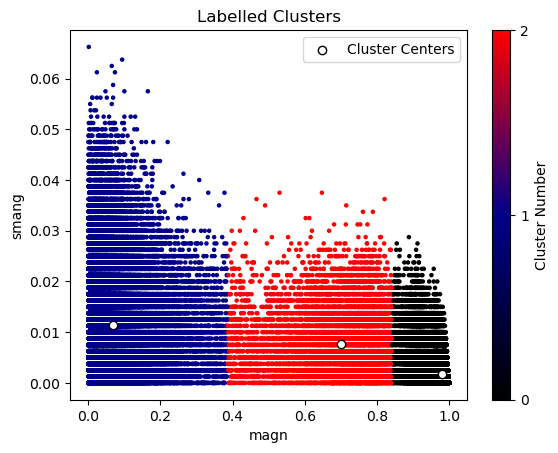

In [44]:
pl.scatter(magn_abs, smagn_abs, s=5, c=kmeans_abs.labels_, cmap=cm)
pl.colorbar(ticks=(0, 1, 2), label="Cluster Number")
pl.scatter(kmeans_abs.cluster_centers_[:,0], kmeans_abs.cluster_centers_[:,1], c="white", marker="o", edgecolor='k', label="Cluster Centers")
pl.legend()

pl.xlabel('magn')
pl.ylabel('smang')
pl.title('Labelled Clusters');

Repeat the grid plot where you pick two configurations for
each cluster:

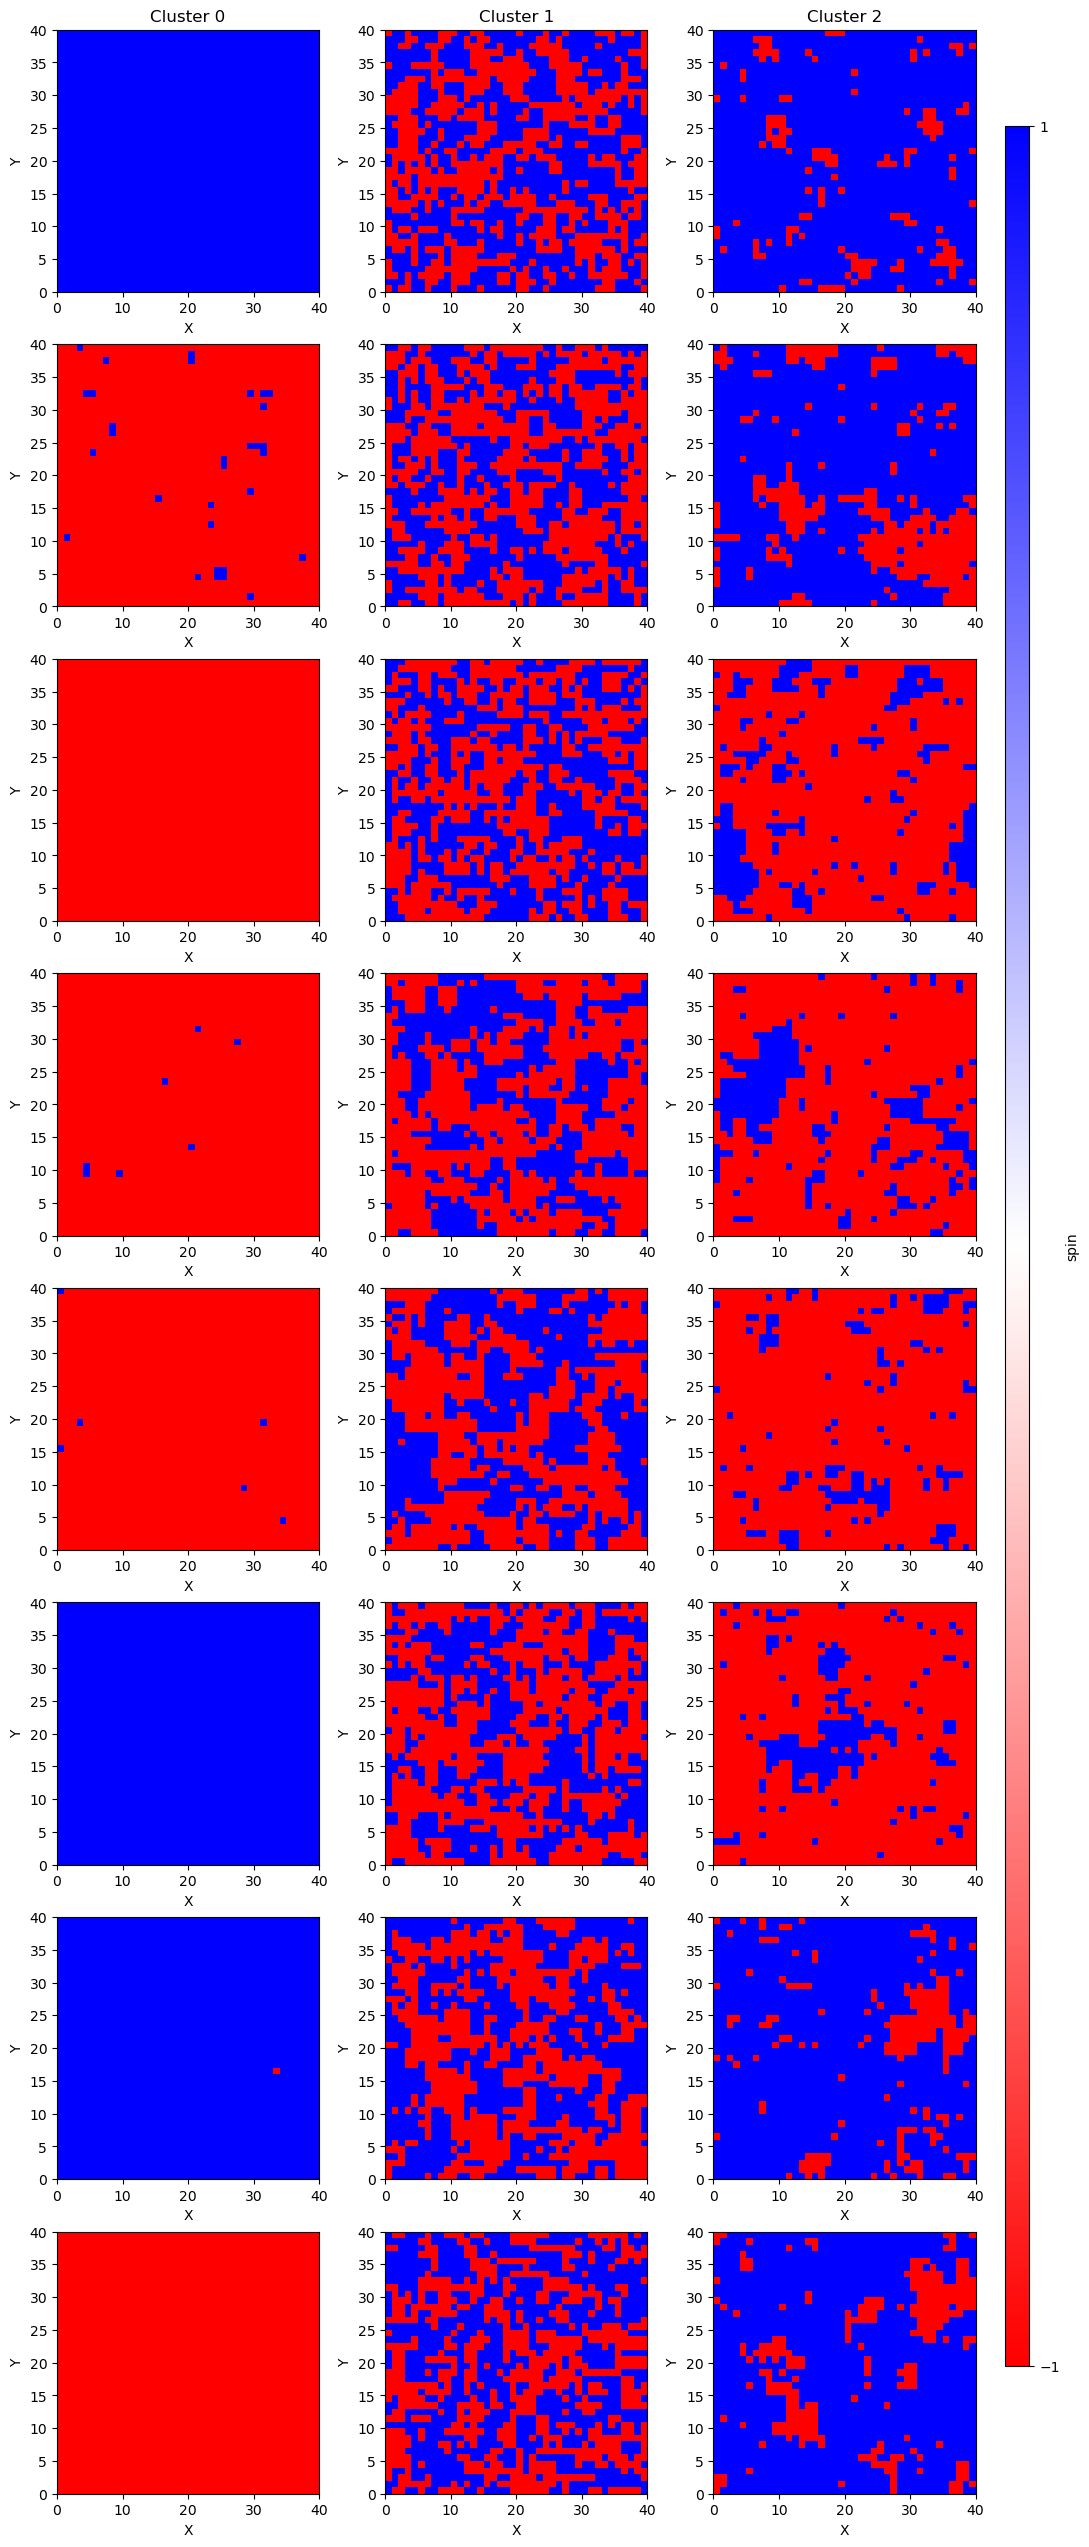

In [45]:
gridplot(kmeans_abs, samples=8)

You should now find **three** regions, that are qualitatively different.

 1. One of the clusters from before is gone. Which one and why?

 2. There is a new cluster that is qualitatively different from the ones
    you found before.  Describe it in terms of temperature where it
    occurs and which kinds of configurations it favours (you might want
    to look at a couple more of configurations for this cluster if you're
    unsure).

### 1)
The clusters where it was either only spin up, or only spin down is gone. Instead Cluster 0 is now a combined version of those clusters. It contains both cases where one spin almost exclusively dominates. This is because if we consider |magn| and |smagn| those cases are identical, and since the have the same energy we should also treat them as identical.

### 2)
The new cluster is **cluster 2** and it corresponds to cases where there is a clearly dominant spin that dictates the sign of the overall magnetisation, however there are still 1 or more big local patches of the opposite spin still present as well. The temperature for these states is right in the middle of our range. The thermal fluctuations are still weak enough for these patches to remain stable not be forced to flip entirely.